In [3]:
import numpy as np
import matplotlib.pyplot as plt
from calcwf import *

# Import pycentricity
import sys
pycentricity_dir = '/home/isobel.romero-shaw/public_html/PYCENTRICITY/pycentricity-plus-precession/ben_project/'
try:
    sys.path.index(pycentricity_dir)
except ValueError:
    sys.path.append(pycentricity_dir)
import pycentricity.waveform as pwf

In [39]:
def m1_m2_from_M_q(M, q):
    """
    Calculates component masses from total mass and mass ratio.

    Parameters:
        M: Total mass.
        q: Mass ratio.

    Returns:
        Masses of binary components.
    """
    
    m2 = M/(1+q)
    m1 = M - m2
    return m1, m2

def gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, sample_rate, phase, distance, thjn, rela=0):
    m1, m2 = m1_m2_from_M_q(M, q)
    parameters = dict(
            mass_1 = m1,
            mass_2 = m2,
            luminosity_distance = distance,
            phase = phase,
            psi = 0,
            ra = 0,
            dec = 0,
            eccentricity = e,
            relativistic_anomaly = rela,
            theta_jn = thjn,
            a_1 = a_1,
            a_2 = a_2,
            phi_12 = np.pi,
            phi_jl = np.pi,
            tilt_1 = np.pi/2,
            tilt_2 = np.pi/2,
            geocent_time = 0

    )
    info = dict(
            reference_frequency=f_low,
            minimum_frequency=f_low,
            sampling_frequency=sample_rate,
            is_only22=True
    )
    hp, hc = pwf.generate_seobnrpe_waveform(parameters, info)
    seob_p = timeseries.TimeSeries(hp, 1/sample_rate, epoch=0)
    seob_c = timeseries.TimeSeries(hc, 1/sample_rate, epoch=0)
    return seob_p -1j*seob_c

# The problem

We want to be able to shift back 2pi in mean anomaly in seobrnpe by calculating the frequency and eccentricity required to evolve through exactly one amplitude modulation before joining up exactly with the original waveform. We are able to do this for TEOBResumS, but applying the same approach here gives a shift significantly greater than 2pi.

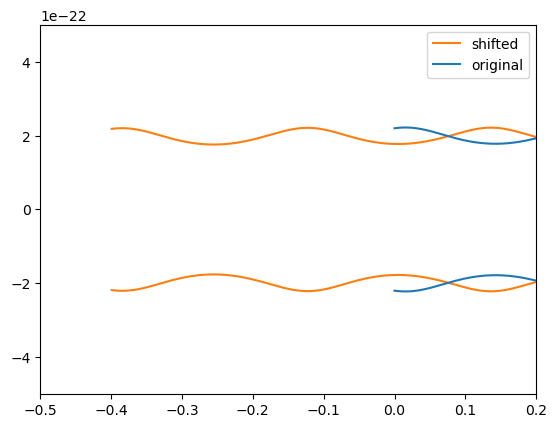

In [19]:
# Parameters
f_low = 10
e = 0.073
M = 60
q = 2
a_1 = 0.7
a_2 = 0.7

# Calculate frequency, eccentricity shifts
s_f = shifted_f(f_low, e, M, q)
s_e = shifted_e(s_f, f_low, e)

# Generates and aligns waveforms in time
wf_ori = gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, 4096, 0, 500, 0)
wf_prec = gen_seobnrpe_wf(s_f, s_e, M, q, a_1, a_2, 4096, 0, 500, 0)
min_len = len(wf_ori)
wf_prec.start_time = -(len(wf_prec)-min_len)/4096

# Plots waveforms
plt.plot(wf_prec.sample_times, np.abs(wf_prec), c='C1', label='shifted')
plt.plot(wf_prec.sample_times, -np.abs(wf_prec), c='C1')
plt.plot(wf_ori.sample_times, np.abs(wf_ori), c='C0', label='original')
plt.plot(wf_ori.sample_times, -np.abs(wf_ori), c='C0')
plt.xlim(-0.5, 0.2)
plt.ylim(-0.5e-21, 0.5e-21)
plt.legend()

We can check whether this is due to the presence of precession by repeating the same waveforms with $a_1=a_2=0$. Turns out we are unable to generate waveform with zero spin (or at least takes prohibitively long) (could be due to wrapper functions in pycentricity or seobnrpe itself, not 100% sure), so as a workaround we will generate with $a_1 = 10^{-2}$, $a_2=0$.

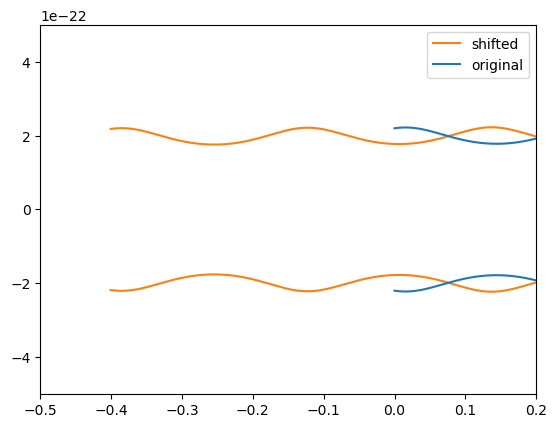

In [18]:
# Parameters
f_low = 10
e = 0.073
M = 60
q = 2
a_1 = 10**-2
a_2 = 0

# Calculate frequency, eccentricity shifts
s_f = shifted_f(f_low, e, M, q)
s_e = shifted_e(s_f, f_low, e)

# Generates and aligns waveforms in time
wf_ori = gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, 4096, 0, 500, 0)
wf_no_prec = gen_seobnrpe_wf(s_f, s_e, M, q, a_1, a_2, 4096, 0, 500, 0)
min_len = len(wf_ori)
wf_no_prec.start_time = -(len(wf_no_prec)-min_len)/4096

# Plots waveforms
plt.plot(wf_no_prec.sample_times, np.abs(wf_no_prec), c='C1', label='shifted')
plt.plot(wf_no_prec.sample_times, -np.abs(wf_no_prec), c='C1')
plt.plot(wf_ori.sample_times, np.abs(wf_ori), c='C0', label='original')
plt.plot(wf_ori.sample_times, -np.abs(wf_ori), c='C0')
plt.xlim(-0.5, 0.2)
plt.ylim(-0.5e-21, 0.5e-21)
plt.legend()

# Starting mean anomaly

First I want to check what value of mean anomaly (i.e. apoapsis, periapsis, somewhere in between) the waveforms are starting with, and crucially whether this is consistent across other waveform parameters.

To do this, let's generate a bunch of waveforms with randomised parameters. If we start them all at the same frequency, rescale such that the starting amplitude is one, and plot all starting at t=0, we should be able to see fairly easily whether they all start at the same point of the amplitude modulation.

0 11.749269091342933 0.03427022320377079 73.02462767139241 2.666594142291915 0.060833656260857266 0.24946999708953838
1 11.26444395255902 0.24992877956504264 61.13713273738071 2.1459140823178466 0.02977942668691349 0.37231561918335304
2 9.868806544372605 0.15497800374029688 71.7116490050935 2.133955014864855 0.6575323644295464 0.030029719987083224
3 10.230915066334948 0.02165748687893779 68.64674237776408 1.001913962401897 0.6373986738803316 0.6680290196068178
4 10.923976362064998 0.13226451257207086 67.42390749887454 1.3549870996122104 0.35199870028432184 0.046940030732797865
5 8.015295588992224 0.27973646210765496 112.00472309252056 2.3266540595606324 0.3681339484963507 0.10388036836097038
6 7.890956945687777 0.03690168774311459 46.47145807848083 1.807206991013209 0.6300700830448623 0.09808561774295982
7 8.682051652369909 0.23149143448460102 113.4996314879247 2.7121700798124997 0.0874984308623899 0.15397668148825533
8 10.760503479722198 0.17516377415479725 78.8446567020873 2.79234939

(-1.5, 1.5)

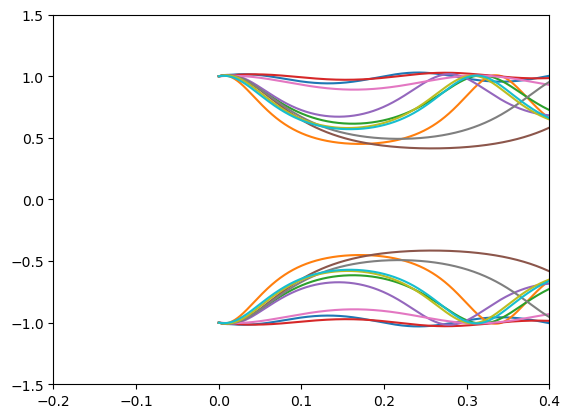

In [28]:
# Parameters
n=10
f_lows = np.random.rand(n)*5+7.5
es = np.random.rand(n)*0.3
Ms = np.random.rand(n)*100 + 30
qs = np.random.rand(n)*2 + 1
a_1s = np.random.rand(n)*0.7
a_2s = np.random.rand(n)*0.7

# Generate and scale waveforms
start_wfs = []
for i, (f_low, e, M, q, a_1, a_2) in enumerate(zip(f_lows, es, Ms, qs, a_1s, a_2s)):
    print(i, f_low, e, M, q, a_1, a_2)
    start_wfs.append(gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, 4096, 0, 500, 0))
    start_wfs[-1] /= np.abs(start_wfs[-1][0])

# Plot waveforms
for i, wf in enumerate(start_wfs):
    plt.plot(wf.sample_times, np.abs(wf), c=f'C{i}')
    plt.plot(wf.sample_times, -np.abs(wf), c=f'C{i}')
plt.xlim(-0.2, 0.4)
plt.ylim(-1.5, 1.5)

Seems like they all start at periapsis, so opposite to teobresums. It does however seem to be consistent, so this should not prevent our method from working.

# Varying phase

Let's try varying individual parameters while keeping other parameters constant, starting with phase.

(-5e-22, 5e-22)

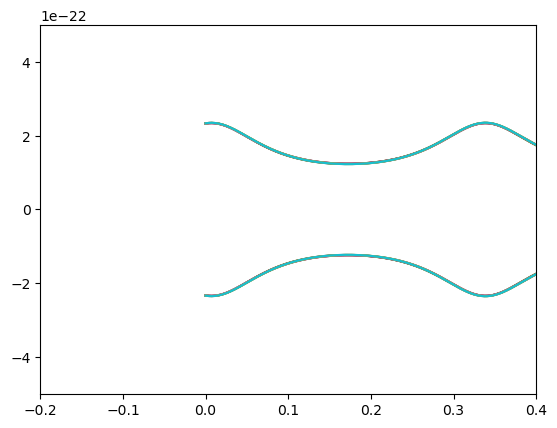

In [40]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2
a_1 = 0.7
a_2 = 0

# Generate waveforms
wfs = []
for phase in np.linspace(0, 2*np.pi, 10, endpoint=False):
    wfs.append(gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, 4096, phase, 500, 0))

# Plot waveforms
for i, wf in enumerate(wfs):
    plt.plot(wf.sample_times, np.abs(wf), c=f'C{i}')
    plt.plot(wf.sample_times, -np.abs(wf), c=f'C{i}')
plt.xlim(-0.2, 0.4)
plt.ylim(-0.5e-21, 0.5e-21)

Phase does not appear to affect the waveform.

# Varying relativistic anomaly

Next let's vary relativistic anomaly.

(-5e-22, 5e-22)

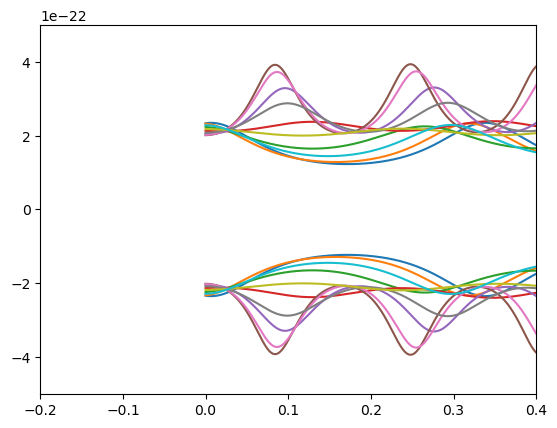

In [42]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2
a_1 = 0.7
a_2 = 0

# Generate waveforms
wfs = []
for rela in np.linspace(0, 2*np.pi, 10, endpoint=False):
    wfs.append(gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, 4096, 0, 500, 0, rela=rela))

# Plot waveforms
for i, wf in enumerate(wfs):
    plt.plot(wf.sample_times, np.abs(wf), c=f'C{i}')
    plt.plot(wf.sample_times, -np.abs(wf), c=f'C{i}')
plt.xlim(-0.2, 0.4)
plt.ylim(-0.5e-21, 0.5e-21)

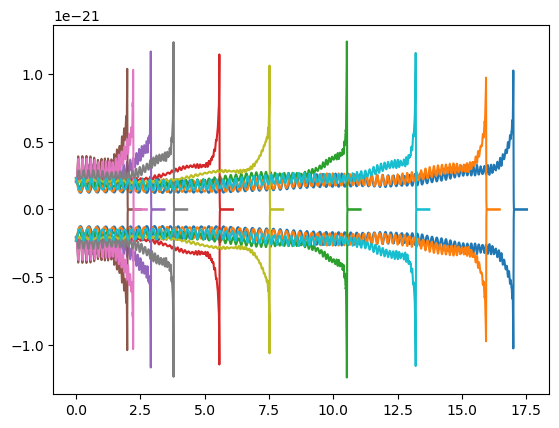

In [44]:
# Plot waveforms
for i, wf in enumerate(wfs):
    plt.plot(wf.sample_times, np.abs(wf), c=f'C{i}')
    plt.plot(wf.sample_times, -np.abs(wf), c=f'C{i}')
# plt.xlim(-0.2, 0.4)
# plt.ylim(-0.5e-21, 0.5e-21)

Initially seems to be quite a large variation, but seems that something very weird is going on as length of waveform also changes dramatically. https://github.com/Shallyn/pyWaveformGenerator/blob/master/waveform.py states that relativistic anomaly parameter is not supported in presence of both eccentricity and precession, so should probably not try to read too much into this.

# Varying frequency, in plane spin

Let's check that the length of the waveform decreases as the starting frequency increases as expected.

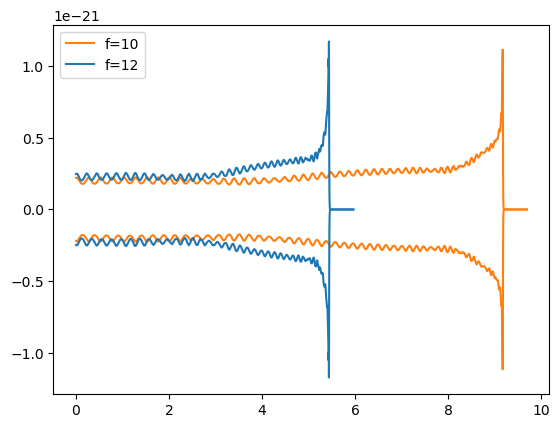

In [38]:
# Parameters
f_low = 10
e = 0.073
M = 60
q = 2
a_1 = 0.7
a_2 = 0.7

# Generates and aligns waveforms in time
wf_low = gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, 4096, 0, 500, 0)
wf_hi = gen_seobnrpe_wf(f_low+2, e, M, q, a_1, a_2, 4096, 0, 500, 0)

# Plots waveforms
plt.plot(wf_low.sample_times, np.abs(wf_low), c='C1', label='f=10')
plt.plot(wf_low.sample_times, -np.abs(wf_low), c='C1')
plt.plot(wf_hi.sample_times, np.abs(wf_hi), c='C0', label='f=12')
plt.plot(wf_hi.sample_times, -np.abs(wf_hi), c='C0')
# plt.xlim(-0.5, 0.2)
# plt.ylim(-0.5e-21, 0.5e-21)
plt.legend()

We can also check that the amount of in plane spin does not affect the frequency evolution of the system.

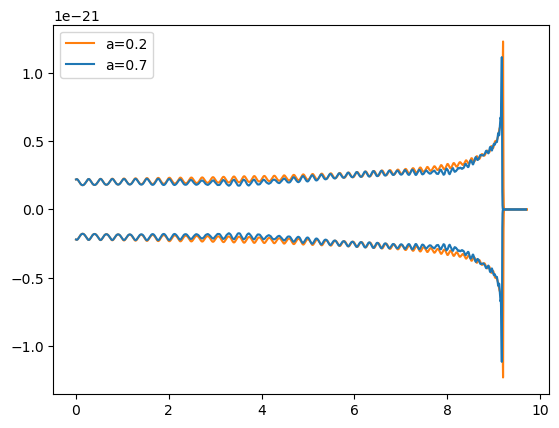

In [37]:
# Parameters
f_low = 10
e = 0.073
M = 60
q = 2
a_1 = 0.7
a_2 = 0.7

# Generates and aligns waveforms in time
wf_low = gen_seobnrpe_wf(f_low, e, M, q, a_1-0.5, a_2-0.5, 4096, 0, 500, 0)
wf_hi = gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, 4096, 0, 500, 0)

# Plots waveforms
plt.plot(wf_low.sample_times, np.abs(wf_low), c='C1', label='a=0.2')
plt.plot(wf_low.sample_times, -np.abs(wf_low), c='C1')
plt.plot(wf_hi.sample_times, np.abs(wf_hi), c='C0', label='a=0.7')
plt.plot(wf_hi.sample_times, -np.abs(wf_hi), c='C0')
plt.legend()

# Varying eccentricity

Next let's check that higher eccentricity causses a shorter waveform.

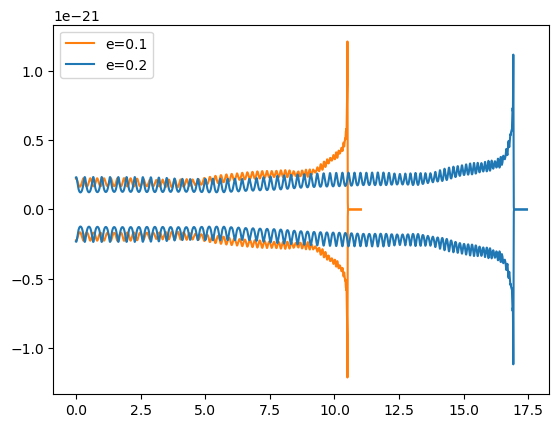

In [45]:
# Parameters
f_low = 10
e = 0.1
M = 60
q = 2
a_1 = 0.7
a_2 = 0.7

# Generates and aligns waveforms in time
wf_low = gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, 4096, 0, 500, 0)
wf_hi = gen_seobnrpe_wf(f_low, e+0.1, M, q, a_1, a_2, 4096, 0, 500, 0)

# Plots waveforms
plt.plot(wf_low.sample_times, np.abs(wf_low), c='C1', label='e=0.1')
plt.plot(wf_low.sample_times, -np.abs(wf_low), c='C1')
plt.plot(wf_hi.sample_times, np.abs(wf_hi), c='C0', label='e=0.2')
plt.plot(wf_hi.sample_times, -np.abs(wf_hi), c='C0')
plt.legend()

It does not!

We had the same issue initially with TEOBResumS due to the frequency being defined as average of the frequency at apo- and peri-apsis. As eccentricity increased, this meant that the keplerian frequency corresponding to the same 'average' frequency actually decreased leading to longer waveforms instead of shorter. We can test this here by employing the keplerian to average frequency conversion function we employed in that case.

In [52]:
def f_kep2ap(f_kep, e):

    num = np.sqrt(1-e**2)
    denom = (1+e)**2
    return f_kep*num/denom

def f_kep2peri(f_kep, e):

    num = np.sqrt(1-e**2)
    denom = (1-e)**2
    return f_kep*num/denom

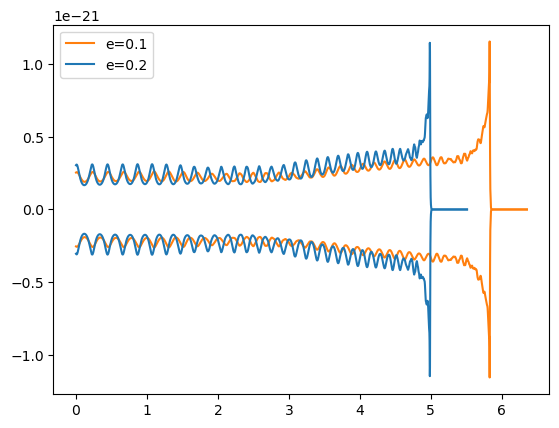

In [53]:
# Parameters
e_1 = 0.1
f_low_1 = f_kep2peri(10, e_1)
e_2 = 0.2
f_low_2 = f_kep2peri(10, e_2)
M = 60
q = 2
a_1 = 0.7
a_2 = 0.7

# Generates and aligns waveforms in time
wf_low = gen_seobnrpe_wf(f_low_1, e_1, M, q, a_1, a_2, 4096, 0, 500, 0)
wf_hi = gen_seobnrpe_wf(f_low_2, e_2, M, q, a_1, a_2, 4096, 0, 500, 0)

# Plots waveforms
plt.plot(wf_low.sample_times, np.abs(wf_low), c='C1', label='e=0.1')
plt.plot(wf_low.sample_times, -np.abs(wf_low), c='C1')
plt.plot(wf_hi.sample_times, np.abs(wf_hi), c='C0', label='e=0.2')
plt.plot(wf_hi.sample_times, -np.abs(wf_hi), c='C0')
plt.legend()

It turns out that treating the frequencies in seobnrpe as the frequency at periapsis (and not 'average' or apoapsis) makes the waveform shorter for higher eccentricity as we should expect.

Now let's test that this allows us to accurately calculate a 2pi shift.

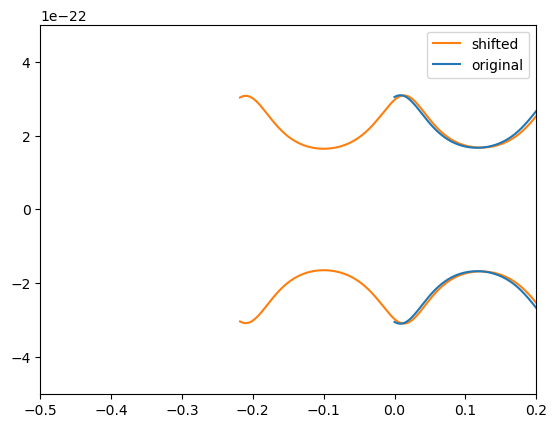

In [59]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2
a_1 = 0.7
a_2 = 0.7

# Calculate frequency, eccentricity shifts
s_f = shifted_f(f_low, e, M, q)
s_e = shifted_e(s_f, f_low, e)

# Generates and aligns waveforms in time
wf_ori = gen_seobnrpe_wf(f_kep2peri(f_low, e), e, M, q, a_1, a_2, 4096, 0, 500, 0)
wf_prec = gen_seobnrpe_wf(f_kep2peri(s_f, s_e), s_e, M, q, a_1, a_2, 4096, 0, 500, 0)
min_len = len(wf_ori)
wf_prec.start_time = -(len(wf_prec)-min_len)/4096

# Plots waveforms
plt.plot(wf_prec.sample_times, np.abs(wf_prec), c='C1', label='shifted')
plt.plot(wf_prec.sample_times, -np.abs(wf_prec), c='C1')
plt.plot(wf_ori.sample_times, np.abs(wf_ori), c='C0', label='original')
plt.plot(wf_ori.sample_times, -np.abs(wf_ori), c='C0')
plt.xlim(-0.5, 0.2)
plt.ylim(-0.5e-21, 0.5e-21)
plt.legend()

This is not perfect, but significantly better that where we were before. Unsurprisingly the shift appears to be more accurate for lower eccentricities, just like with teobresums (but overall less accurate in seobnrpe case).